In [1]:
# installlation required
!pip install Lifetimes
!pip install openpyxl

   ---------------------------------------- 0.0/584.2 kB ? eta -:--:--
    --------------------------------------- 10.2/584.2 kB ? eta -:--:--
   -- ------------------------------------ 30.7/584.2 kB 435.7 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/584.2 kB 762.6 kB/s eta 0:00:01
   --------------------- ------------------ 307.2/584.2 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 584.2/584.2 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
   ---------------------------------------- 51.5/51.5 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install squarify

In [3]:
# libraries
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
import squarify  # treemap 
import warnings 
warnings.filterwarnings("ignore")

In [6]:
df_2010_2011 = pd.read_csv('C:/Users/user/Desktop/Projects/CRM_Analytics/Year 2010-2011.csv', encoding='ISO-8859-1')

In [7]:
df_2010_2011.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df_2010_2011.shape

(541910, 8)

In [9]:
# Invoice: The unique number of each transaction, namely the invoice. Aborted operation if it starts with C.
# We deal with purchases in our analysis. Therefore, we have excluded returns from the data.
df_2010_2011 = df_2010_2011[~df_2010_2011["Invoice"].str.contains("C", na=False)]

In [10]:
df_2010_2011.shape

(532622, 8)

In [11]:
# Creating a function for reading the imported dataset.
def check_df(dataframe):
    print(dataframe.shape)
    print(dataframe.columns)
    print(dataframe.dtypes)
    print(dataframe.head())
    print(dataframe.tail())
    print(dataframe.describe().T)

check_df(df_2010_2011)

(532622, 8)
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  Price  Customer ID         Country  
0  12/1/2010 8:26   2.55      17850.0  United Kingdom  
1  12/1/2010 8:26   3.39      17850.0  United Kingdom  
2  12/1/2010 8:26   2.75      17850.0  United Kingdom  
3  12/1

In [12]:
df_2010_2011.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    134697
Country             0
dtype: int64

In [13]:
df_2010_2011.dropna(inplace = True)

In [14]:
df_2010_2011.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [15]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df_2010_2011, "Quantity")
replace_with_thresholds(df_2010_2011, "Price")

In [16]:
# How much sales has been recorded for each product

df_product = df_2010_2011.groupby("Description").agg({"Quantity":"count"})
df_product.reset_index(inplace=True)
df_product

,Description,Quantity
0,4 PURPLE FLOCK DINNER CANDLES,39
1,50'S CHRISTMAS GIFT BAG LARGE,109
2,DOLLY GIRL BEAKER,138
3,I LOVE LONDON MINI BACKPACK,70
4,I LOVE LONDON MINI RUCKSACK,1
...,...,...
3872,ZINC T-LIGHT HOLDER STARS SMALL,238
3873,ZINC TOP 2 DOOR WOODEN SHELF,9
3874,ZINC WILLIE WINKIE CANDLE STICK,192
3875,ZINC WIRE KITCHEN ORGANISER,12


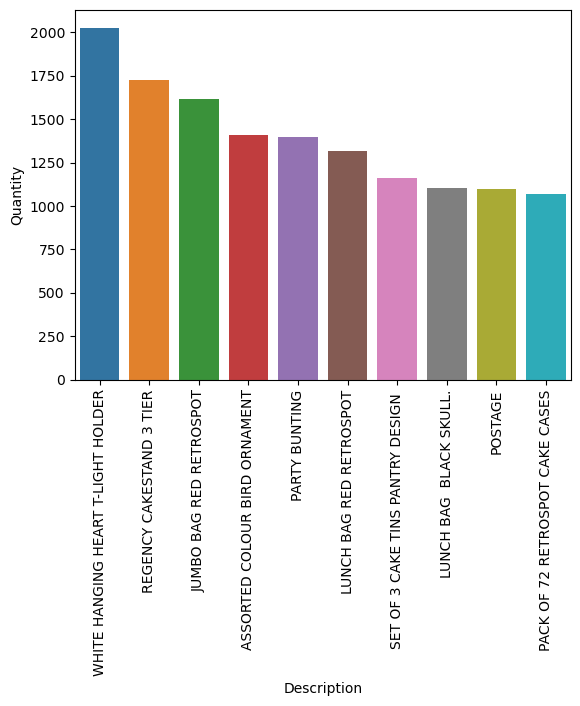

In [17]:
# Plotting top 10 products by quantity

top_pr= df_product.sort_values(by="Quantity",ascending=False).head(10)

sns.barplot(x="Description", y="Quantity", data=top_pr)
plt.xticks(rotation=90)
plt.show()

In [18]:
# total price per invoice
df_2010_2011["TotalPrice"] = df_2010_2011["Price"] * df_2010_2011["Quantity"]

In [19]:
df_2010_2011.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [20]:
# About RFM
# The RFM method is a tool for assessing consumer value. It's frequently utilized in database marketing and direct marketing, as well as retail and professional services.
# RFM stands for the three dimensions:
# Recency: How recently did the customer purchase, the difference between today and the customer's last purchase date, in days
# Frequency: How often do they purchase, customer's shopping frequency
# Monetary Value: How much do they spend?

In [21]:
# Determining the analysis date for the recency

df_2010_2011["InvoiceDate"] = pd.to_datetime(df_2010_2011["InvoiceDate"])
df_2010_2011["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

In [22]:
# Generating RFM metrics

rfm = df_2010_2011.groupby("Customer ID").agg({"InvoiceDate": lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                    "Invoice": lambda Invoice: Invoice.nunique(),
                                    "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ["recency","frequency","monetary"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4339.0,93.041484,100.007757,1.0,18.000,51.00,142.500,374.000
frequency,4339.0,4.271952,7.705493,1.0,1.000,2.00,5.000,210.000
monetary,4339.0,1891.748117,7705.372078,0.0,303.125,662.59,1630.445,266163.525


In [23]:
# monetary, the min value of the total money paid can't be 0
# let's remove them from the data

rfm = rfm[rfm["monetary"] > 0]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,93.059474,100.012264,1.00,18.0000,51.0,142.7500,374.000
frequency,4338.0,4.272706,7.706221,1.00,1.0000,2.0,5.0000,210.000
monetary,4338.0,1892.184204,7706.206805,3.75,303.3075,663.1,1631.1075,266163.525


In [24]:
# Generating RFM Score

# recency_score
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
# frequency_score
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# monetary_score
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])

#  RFM Score
#rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str))
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,326,1,310.44,1,1,2,112
12347.0,3,7,4310.00,5,5,5,555
12348.0,76,4,1770.78,2,4,4,244
12349.0,19,1,1491.72,4,1,4,414
12350.0,311,1,331.46,1,1,2,112
12352.0,37,8,1756.34,3,5,4,354
12353.0,205,1,89.00,1,1,1,111
12354.0,233,1,1079.40,1,1,4,114
12355.0,215,1,459.40,1,1,2,112


In [25]:
import re

seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

# Remove numbers from the 'segment' column using regular expressions
rfm['segment'] = rfm['segment'].apply(lambda x: re.sub(r'\d', '', x))

rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.0,326,1,310.44,1,1,2,112,Hibernating
12347.0,3,7,4310.00,5,5,5,555,Champions
12348.0,76,4,1770.78,2,4,4,244,At Risk
12349.0,19,1,1491.72,4,1,4,414,At Risk
12350.0,311,1,331.46,1,1,2,112,Hibernating
12352.0,37,8,1756.34,3,5,4,354,Loyal Customers
12353.0,205,1,89.00,1,1,1,111,Hibernating
12354.0,233,1,1079.40,1,1,4,114,Hibernating
12355.0,215,1,459.40,1,1,2,112,Hibernating


In [26]:
# Grouping RFM mean and frequency values according to segments
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
About to Sleep        28.640449   178   2.106742   178   303.960365   178
At Risk              126.726684   772   2.549223   772   914.094554   772
Can't Lose           119.108108    74   7.378378    74  2695.778784    74
Champions              6.114219   429  16.275058   429  8887.130979   429
Hibernating          162.200000  1545   1.099029  1545   350.658076  1545
Loyal Customers       28.827519  1032   5.907946  1032  2551.308145  1032
Need Attention        36.068670   233   2.386266   233   913.709549   233
New Customers         12.000000     1   7.000000     1   198.230000     1
Potential Loyalists    7.690141    71   4.154930    71   675.763239    71
Promising              4.333333     3   3.666667     3   217.946667     3

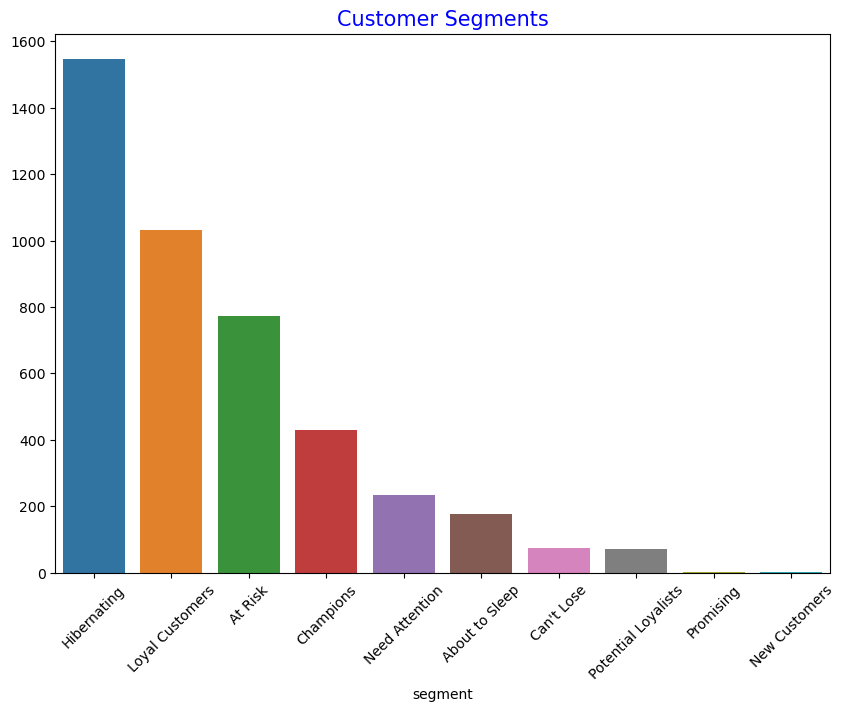

In [27]:
segment= rfm["segment"].value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=segment.index,y=segment.values)
plt.xticks(rotation=45)
plt.title('Customer Segments',color = 'blue',fontsize=15)
plt.show()

In [28]:
# Treemap Visualization
df_treemap = rfm.groupby('segment').agg('count').reset_index()
df_treemap.head()

,segment,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,About to Sleep,178,178,178,178,178,178,178
1,At Risk,772,772,772,772,772,772,772
2,Can't Lose,74,74,74,74,74,74,74
3,Champions,429,429,429,429,429,429,429
4,Hibernating,1545,1545,1545,1545,1545,1545,1545


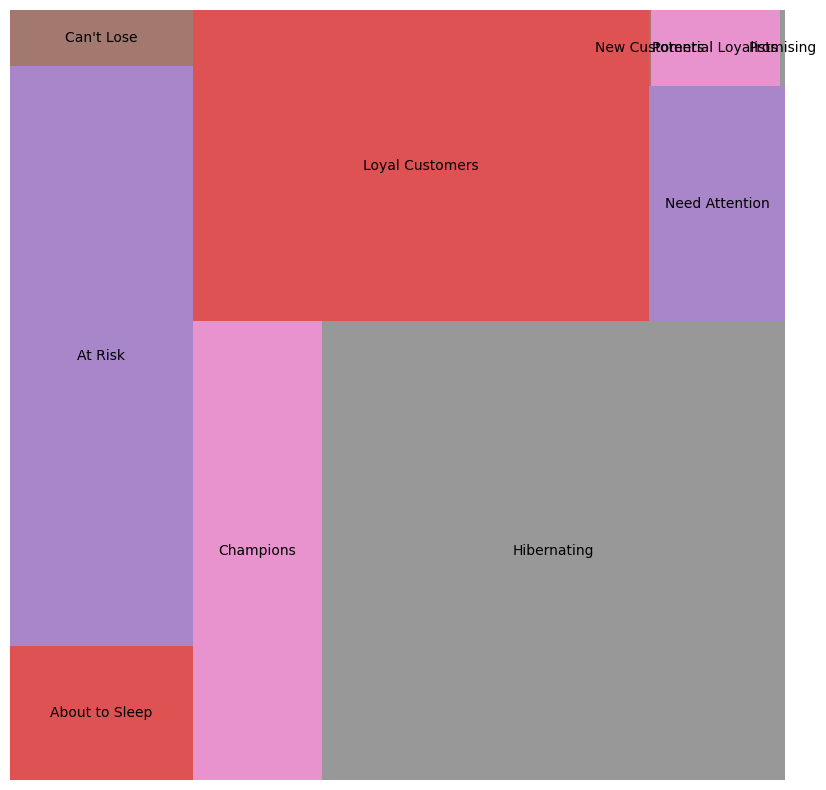

In [29]:
fig, ax = plt.subplots(1, figsize = (10,10))

squarify.plot(sizes=df_treemap['RFM_SCORE'], 
              label=df_treemap['segment'], 
              alpha=.8,
              color=['tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
             )
plt.axis('off')
plt.show()

In [30]:
# Preparing Data for CLTV

# Determining the analysis date for the recency
df_2010_2011["InvoiceDate"] = pd.to_datetime(df_2010_2011["InvoiceDate"])
df_2010_2011["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

In [31]:
cltv_df = df_2010_2011.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,0,326,1,310.44
12347.0,365,368,7,4310.00
12348.0,282,359,4,1770.78
12349.0,0,19,1,1491.72
12350.0,0,311,1,331.46


In [32]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df = cltv_df[cltv_df["monetary"] > 0]

cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0,52.142857,52.571429,7,615.714286
12348.0,40.285714,51.285714,4,442.695000
12352.0,37.142857,42.428571,8,219.542500
12356.0,43.142857,46.571429,3,937.143333
12358.0,21.285714,21.571429,2,575.210000


In [33]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

In [34]:
# 1 week expected purchase
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_week", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12748.0,53.142857,53.428571,210,154.192429,3.265158
14911.0,53.142857,53.428571,201,691.710100,3.126645
17841.0,53.000000,53.428571,124,330.134355,1.940290
13089.0,52.285714,52.857143,97,606.362474,1.537528
14606.0,53.142857,53.428571,93,130.139032,1.463999
15311.0,53.285714,53.428571,91,667.779121,1.433717
12971.0,52.571429,53.285714,86,127.485872,1.357024
14646.0,50.428571,50.714286,74,3596.804392,1.222517
13408.0,53.000000,53.428571,62,453.500645,0.986249


In [35]:
# 1 month expected purchase
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_month", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12748.0,53.142857,53.428571,210,154.192429,3.265158,13.025670
14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095
17841.0,53.000000,53.428571,124,330.134355,1.940290,7.740345
13089.0,52.285714,52.857143,97,606.362474,1.537528,6.133456
14606.0,53.142857,53.428571,93,130.139032,1.463999,5.840269
15311.0,53.285714,53.428571,91,667.779121,1.433717,5.719467
12971.0,52.571429,53.285714,86,127.485872,1.357024,5.413481
14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360
13408.0,53.000000,53.428571,62,453.500645,0.986249,3.934373


In [36]:
# Using Gamma Gamma Model

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [37]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

cltv_df.sort_values("expected_average_profit", ascending=False).head(20)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190
12590.0,0.000000,30.285714,2,4591.172500,0.011536,0.045934,5029.409866
12435.0,26.857143,38.285714,2,3914.945000,0.076313,0.304072,4288.935706
12409.0,14.714286,26.142857,3,3690.890000,0.117435,0.467406,3918.807905
14088.0,44.571429,46.142857,13,3864.554615,0.260297,1.037956,3917.128640
18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702
12753.0,48.428571,51.857143,6,3571.565000,0.126058,0.502765,3678.576111
14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159
15749.0,13.857143,47.571429,3,3028.780000,0.027979,0.111556,3216.048315


In [38]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  
                                   freq="W",  
                                   discount_rate=0.01)

In [39]:
# Reset index
cltv = cltv.reset_index()
# Merging the main table and the forecast values table
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
# sorting
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,108691.798098
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,92510.277867
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,56135.700476
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,53978.799538
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,53427.083098
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747475,2.981719,2874.198462,53004.426828
874,14156.0,51.571429,53.142857,55,2104.026727,0.877551,3.500701,2110.754090,45708.064488
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508850,2.029876,2950.579794,37047.560382
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478081,1.906950,2223.884691,26217.823311
650,13694.0,52.714286,53.428571,50,1275.700500,0.800854,3.194773,1280.218167,25301.558174


In [40]:
# 1 Month CLTV:
cltv_1 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=1,  # 1 month
                                   freq="W",  # frequency of T
                                   discount_rate=0.01)

cltv_1.head()
cltv_1= cltv_1.reset_index()
cltv_1 = cltv_df.merge(cltv_1, on="Customer ID", how="left")
cltv_1.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,18902.050248
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,16081.184785
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,9948.435203
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,9395.535477
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,9284.571962
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747475,2.981719,2874.198462,9214.194426
874,14156.0,51.571429,53.142857,55,2104.026727,0.877551,3.500701,2110.754090,7944.525063
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508850,2.029876,2950.579794,6439.495406
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478081,1.906950,2223.884691,4559.551262
1754,16000.0,0.000000,0.428571,3,2335.120000,0.422126,1.664397,2479.801743,4432.241509


In [41]:
# 12 Month CLTV Forecast:

cltv_12 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=12,  
                                   freq="W", 
                                   discount_rate=0.01)

cltv_12.head()
cltv_12 = cltv_12.reset_index()
cltv_12 = cltv_df.merge(cltv_12, on="Customer ID", how="left")
cltv_12.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,207476.975621
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,176649.342133
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,105762.291340
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,102964.326961
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,102044.017958
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747475,2.981719,2874.198462,101209.239811
874,14156.0,51.571429,53.142857,55,2104.026727,0.877551,3.500701,2110.754090,87288.675475
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508850,2.029876,2950.579794,70747.402561
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478081,1.906950,2223.884691,50044.760217
650,13694.0,52.714286,53.428571,50,1275.700500,0.800854,3.194773,1280.218167,48320.424555


In [42]:
# Normalization 0-1 Range For CLV Values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

cltv_final.sort_values(by="scaled_clv", ascending=False).head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,108691.798098,1.000000
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,92510.277867,0.851125
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,56135.700476,0.516467
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,53978.799538,0.496623
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,53427.083098,0.491547


In [43]:
# Segmentation of Customers
cltv_final["segment"] = pd.qcut(cltv_final["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.head()

cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv,segment
0,12347.0,52.142857,52.571429,7,615.714286,0.141283,0.563516,631.911974,2200.757918,0.020248,A
1,12348.0,40.285714,51.285714,4,442.695000,0.091963,0.366752,463.745539,1050.352322,0.009664,B
2,12352.0,37.142857,42.428571,8,219.542500,0.182395,0.727126,224.886669,1007.740746,0.009272,B
3,12356.0,43.142857,46.571429,3,937.143333,0.086160,0.343511,995.997679,2109.557904,0.019409,A
4,12358.0,21.285714,21.571429,2,575.210000,0.122258,0.486232,631.900951,1870.555107,0.017210,A


In [44]:
# Examination of Segments
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                           recency                \
              count         sum          mean   count           sum   
segment                                                               
D               712  11073488.0  15552.651685     712  15705.142857   
C               711  10895576.0  15324.298172     711  21747.142857   
B               711  10910905.0  15345.857947     711  20974.142857   
A               711  10626242.0  14945.488045     711  22414.428571   

                       T                          frequency  ...  \
              mean count           sum       mean     count  ...   
segment                                                      ...   
D        22.057785   712  28780.285714  40.421750       712  ...   
C        30.586699   711  27054.428571  38.051236       711  ...   
B        29.499498   711  24746.428571  34.805103       711  ...   
A        31.525216   711  24596.142857  34.593731       711  ...   

        expected_purc_1_month expected_average_profit                 \
                         mean                   count            sum   
segment                                                                
D                    0.283548                     712  141735.786739   
C                    0.480978                     711  206064.393038   
B                    0.645186                     711  280456.503624   
A                    1.089390                     711  487558.495359   

                      clv                            scaled_clv             \
               mean count           sum         mean      count        sum   
segment                                                                      
D        199.067116   712  1.983117e+05   278.527637        712   1.824532   
C        289.823338   711  5.261275e+05   739.982459        711   4.840545   
B        394.453592   711  9.498650e+05  1335.956469        711   8.739068   
A        685.736280   711  3.069753e+06  4317.514602        711  28.242728   

                   
             mean  
segment            
D        0.002563  
C        0.006808  
B        0.012291  
A        0.039723  

[4 rows x 30 columns]

In [45]:
# Examination of Segments
cltv_final.groupby("segment").agg({"count", "mean"})

Customer ID               recency                T             \
              count          mean   count       mean count       mean   
segment                                                                 
D               712  15552.651685     712  22.057785   712  40.421750   
C               711  15324.298172     711  30.586699   711  38.051236   
B               711  15345.857947     711  29.499498   711  34.805103   
A               711  14945.488045     711  31.525216   711  34.593731   

        frequency            monetary             expected_purc_1_week  \
            count       mean    count        mean                count   
segment                                                                  
D             712   3.066011      712  183.613784                  712   
C             711   4.091421      711  271.527363                  711   
B             711   5.423347      711  373.926814                  711   
A             711  11.383966      711  659.761035                  711   

                  expected_purc_1_month           expected_average_profit  \
             mean                 count      mean                   count   
segment                                                                     
D        0.071198                   712  0.283548                     712   
C        0.120785                   711  0.480978                     711   
B        0.162117                   711  0.645186                     711   
A        0.273634                   711  1.089390                     711   

                      clv              scaled_clv            
               mean count         mean      count      mean  
segment                                                      
D        199.067116   712   278.527637        712  0.002563  
C        289.823338   711   739.982459        711  0.006808  
B        394.453592   711  1335.956469        711  0.012291  
A        685.736280   711  4317.514602        711  0.039723